In [ ]:
#default_exp simclr_v2

# SimCLR v2

> [Big Self-Supervised Models are Strong Semi-Supervised Learners](https://arxiv.org/pdf/2006.10029.pdf)

In [ ]:
#export
from fastai.vision.all import *
import kornia

## Data Augmentation

In [ ]:
#export
def get_aug_pipe(size, stats=imagenet_stats, s=.6, color=True, xtra_tfms=[]):
    "SimCLR augmentations"
    tfms = []
    tfms += [kornia.augmentation.RandomResizedCrop((size, size), scale=(0.2, 1.0), ratio=(3/4, 4/3))]
    tfms += [kornia.augmentation.RandomHorizontalFlip()]
    
    if color: tfms += [kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)]
    if color: tfms += [kornia.augmentation.RandomGrayscale(p=0.2)]    
    tfms += xtra_tfms
    if stats is not None: tfms += [Normalize.from_stats(*stats)]
    
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

This creates a data augmentation `Pipeline`. Define `size` for random resized crop, choose whether to use color transforms with `color` boolean and optionally pass your own custom transforms with `xtra_tfms`

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

In [ ]:
#hide
aug = get_aug_pipe(224)
x = aug(t)
assert x.shape[-2:] == torch.Size([224,224])

Default SimCLR augmentations side by side with the original image

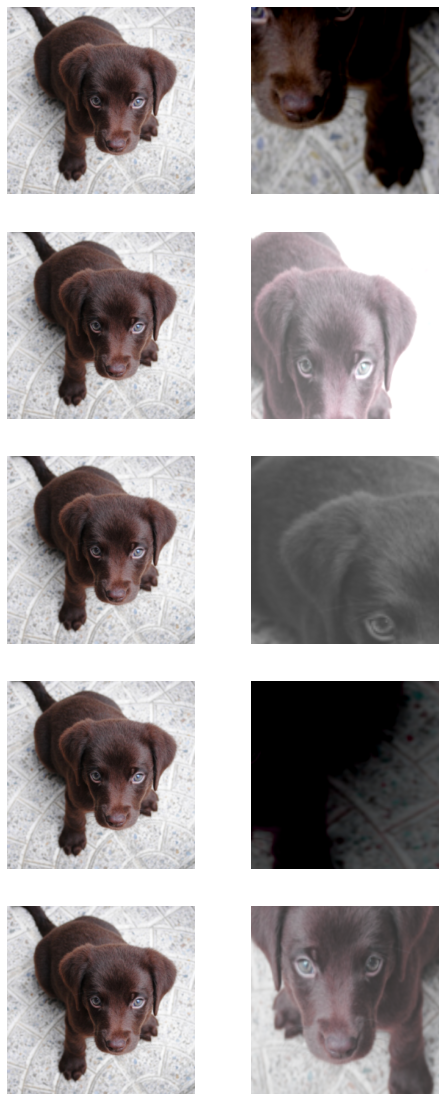

In [ ]:
aug = get_aug_pipe(224)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

Default SimCLR augmentations with extra transforms passed by user side by side with the original image

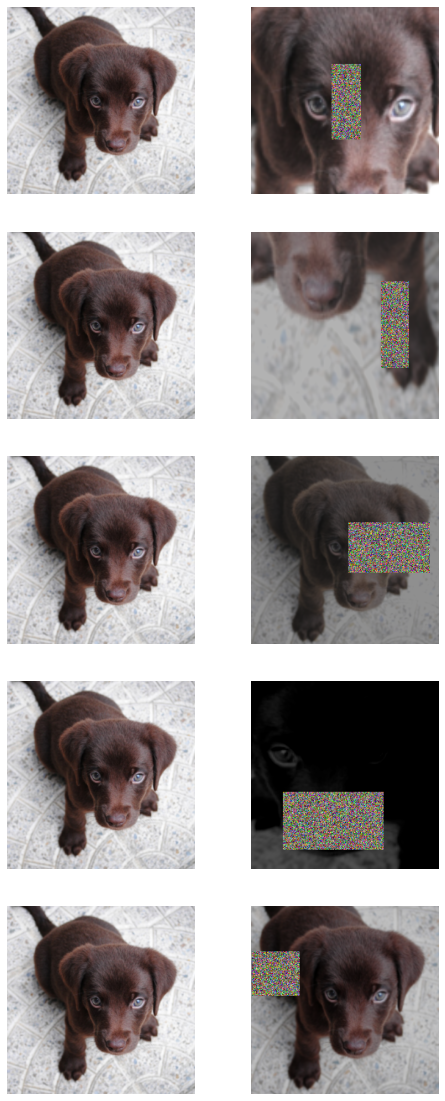

In [ ]:
aug = get_aug_pipe(224, xtra_tfms=[RandomErasing(p=1.)])
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/simclr_v2.png)

In [ ]:
#export
def create_encoder(arch, n_in=3, pretrained=True, cut=None, concat_pool=True):
    "Create encoder from a given arch backbone"
    encoder = create_body(arch, n_in, pretrained, cut)
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    return nn.Sequential(*encoder, pool, Flatten())

This function creates an encoder which essentially outputs the embeddings/representations we learn through self-supervised training. It uses `create_body` function from fastai, you can pass any `arch` that is supported, specify number of input channels with `n_in`, optionally load `pretrained` weights if available and or use `concat_pool`. Instead of directly using this function you will most likely call `create_simclr_model` when creating your model.

In [ ]:
encoder = create_encoder(xresnet152, n_in=3, pretrained=False, concat_pool=True)
encoder[-2:]

Sequential(
  (8): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (9): Flatten(full=False)
)

One thing authors argue compared to previous SimCLR framework is that scaling up the model from ResNet-50 to
ResNet-152 (3×+SK) gave 29% relative gain in top-1 accuracy when fine tuning with only 1% labeled data.

In [ ]:
#export
class MLP(Module):
    "MLP module as described in paper"
    def __init__(self, dim, hidden_size=None, projection_size=256):
        if not hidden_size: hidden_size=dim
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(dim, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
x = torch.randn([1,5])
F.softmax(x, dim=1), F.softmax(x/2, dim=1)

(tensor([[0.1067, 0.1445, 0.4828, 0.1710, 0.0949]]),
 tensor([[0.1538, 0.1791, 0.3273, 0.1948, 0.1451]]))

In [ ]:
BCEWithLogitsLoss()

TypeError: binary_cross_entropy_with_logits() missing 2 required positional arguments: 'input' and 'target'

Next new change in SimCLR-v2 is a 3 layer MLP head instead of 2. Fine tune happens starting from the middle layer of MLP not only from encoder as it did previouly in SimCLR. Also, hidden size is set equal to input dimension as stated in the paper: 

> In our experiments, we set the width of projection head’s middle layers to that of its input, so it is also
adjusted by the width multiplier. However, a wider projection head improves performance even when the base
network remains narrow.

In [ ]:
#export
class SimCLRv2Model(Module):
    "Compute predictions of concatenated xi and xj" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

In [ ]:
#export
def create_simclrv2_model(arch=xresnet101, n_in=3, pretrained=True, cut=None, concat_pool=True, projection_size=256):
    "Create SimCLR from a given arch"
    encoder = create_encoder(arch, n_in, pretrained, cut, concat_pool)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = MLP(representation.size(1), projection_size=projection_size)     
    apply_init(projector)
    return SimCLRv2Model(encoder, projector)

This function creates a `class SimCLRV2Model` with specified arguments. It uses `create_encoder` which is defined earlier. You can also define  `projection_size` and `hidden_size` for the `MLP`, by default `hidden_size` is set equal to input dimension.

In [ ]:
model = create_simclrv2_model(pretrained=False)
model.projector

MLP(
  (net): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=4096, out_features=256, bias=True)
  )
)

## SimCLRv2 Callback

> Important: (TODO) Memory mechanism from MOCO. Paper claims 1% improvement in linear evaluation and fine-tuning, so it's ignored for now. This is mainly valuable when large batch size can't be obtained for enough negative sampling.

In [ ]:
#export
def remove_diag(x):
    bs = x.shape[0]
    return x[~torch.eye(bs).bool()].reshape(bs,bs-1)

In [ ]:
#export
class SimCLRv2Loss(Module):
    "SimCLR loss function"
    def __init__(self, temp=0.1):
        self.temp = temp
        
    def forward(self, inp, targ):
        bs,feat = inp.shape
        csim = F.cosine_similarity(inp, inp.unsqueeze(dim=1), dim=-1)/self.temp
        csim = remove_diag(csim)
        targ = remove_diag(torch.eye(targ.shape[0], device=inp.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(csim, targ)

Loss function allows you to specify `temp` which is the temperature parameter to be used in cross entropy loss. It calculates cosine similarity of different views of the same image to be used as the prediction

In [ ]:
x = torch.randn(16,128)
y = torch.arange(16).roll(16//2)
loss_func = SimCLRv2Loss(temp=0.1)
loss_func(x,y)

tensor(3.1629)

In [ ]:
#export
class SimCLRv2(Callback):
    "SimCLR callback"
    def __init__(self, size=256, **aug_kwargs):
        self.aug1 = get_aug_pipe(size, **aug_kwargs)
        self.aug2 = get_aug_pipe(size, **aug_kwargs)
                    
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
        
    def show_one(self):
        xb = TensorImage(self.learn.xb[0])
        bs = len(xb)//2
        i = np.random.choice(bs)
        xb = self.aug1.decode(xb.to('cpu').clone()).clamp(0,1)
        images = [xb[i], xb[bs+i]]
        show_images(images)

You can pass `size` to define the random resized crop size and other data augmentation arguments defined in `get_aug_pipe` through `aug_kwargs`. Also, with `show_one()` method you can inspect data augmentations as a sanity check

## Distill Callback

In [ ]:
class Distill(Callback):
    "Knowledge Distillation callback, distills from a given teacher"
    def __init__(self, teacher:Learn, T=1.0):
        store_attr("teacher,T")
        
    def before_fit(self):
        self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf
            
    def after_fit(self):
        self.learn.loss_func = self.old_lf
    
    def before_batch(self):
        preds, _ = self.teacher.get_preds(*self.xb)
        self.yb = (torch.softmax(preds/T, dim=1),)
        
    def lf(self, pred, *yb):
        return F.binary_cross_entropy(torch.softmax(pred/T, dim=1), *yb)

In [ ]:
class DistillSemiSupervised(Callback):
    "Knowledge Distillation callback, distills from a given teacher with partial labels"
    def __init__(self, teacher:Learner, T=1.0, alpha=0.9):
        store_attr("teacher,T,alpha")
        
    def before_fit(self):
        self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf
            
    def after_fit(self):
        self.learn.loss_func = self.old_lf
    
    def before_batch(self):
        preds, _ = self.teacher.get_preds(*self.xb)
        self.yb = (torch.softmax(preds/T, dim=1), self.y)
        
    def lf(self, pred, yb1, yb2):
        distill_loss = F.binary_cross_entropy(torch.softmax(pred/self.T, dim=1), yb1)
        sup_loss = self.old_lf(pred, yb2)
        return (1-self.alpha)*sup_loss + (self.alpha)*distill_loss

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=2, after_item=[ToTensor(), IntToFloatTensor()])

In [ ]:
model = create_simclrv2_model(arch=resnet18, n_in=1, pretrained=False)
learn = Learner(dls, model, SimCLRv2Loss(temp=0.5),
                cbs=[SimCLRv2(size=28, color=False, stats=None),
                     ShortEpochCallback(0.001)])

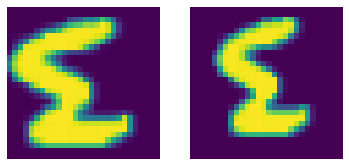

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_cl_rv2.show_one()

In [ ]:
#hide
learn._split(b)
learn('before_batch')
out = learn.model(*learn.xb)
assert out.shape[0] == 4

In [ ]:
learn.fit(1)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00-utils.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
